In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import time
from tqdm.auto import tqdm

In [ ]:
class TrianglesGenerator:
    
    def __init__(self, file, chromosome_length, population_size, number_of_iterations,\
                 number_of_offspring, number_of_parents, sigma_t, sigma_c, new_triangles_frequency=100, log_frequency=200,\
                 mutation_probability = 0.3, frames_frequency=10):
        
        self.A = plt.imread(file)
        self.width, self.height = self.A.shape[1], self.A.shape[0]
        self.actual_img = Image.new("RGB", (self.width, self.height))
        self.objective_function = self.objective_function_mse
        self.chromosome_length = chromosome_length
        self.population_size = population_size
        self.number_of_iterations = number_of_iterations
        self.number_of_offspring = number_of_offspring
        self.number_of_parents = number_of_parents
        self.mut_ppb = mutation_probability
        self.frames_frequency = frames_frequency
        self.new_triangles_frequency = new_triangles_frequency
        self.log_frequency = log_frequency
        self.c_domain = np.array([255,255,255,255])
        self.t_domain = np.array([self.width - 1, self.height - 1])
        self.num_trian = 0
        self.sigma_t = sigma_t
        self.sigma_c = sigma_c
        
    def reset_act_image(self):
        self.actual_img = Image.new("RGB", (self.width, self.height))
        
    def show_image(self, image):
        plt.imshow(image)
        plt.show()

    def save_image(self, image, out):
        im = Image.fromarray(np.asarray(image))
        im.save(out)
        
    def draw_triangle(self, triangle, colors, B):
        t_draw = ImageDraw.Draw(B, "RGBA")
        coords = tuple(map(tuple, triangle))
        t_draw.polygon(coords, colors)
    
    def show_sequence(self, s_t, s_c):
        B = Image.new("RGB", (self.width, self.height))
        for i in range(len(s_t)):
            for j in range(s_t[i].shape[0]):
                self.draw_triangle(s_t[i][j], tuple(s_c[i][j]), B)
        return B
    
    def create_triangles(self, T, C):
        B = self.actual_img.copy()
        for i in range(T.shape[0]):
            self.draw_triangle(T[i], tuple(C[i]), B)
        return B
    
    def update_act_img(self, T, C):
        for i in range(T.shape[0]):
            self.draw_triangle(T[i], tuple(C[i]), self.actual_img)
    
    def objective_function_mse(self, T, C):
        B = self.create_triangles(T, C)
        x1 = np.asarray(self.A, dtype=int)
        x2 = np.asarray(B, dtype=int)
        return np.sum((x1 - x2)**2) / (self.width * self.height)
    
    def generate_random_population(self):
        
        self.current_population_triangles = np.around(
            self.t_domain * np.random.rand(self.population_size, self.chromosome_length, 3, 2))
            
        self.current_population_colors = np.around(
                self.c_domain * np.random.rand(self.population_size, self.chromosome_length, 4))
    
    def evolve(self, debug=False):
        
        self.best_sequence_t = []
        self.best_sequence_c = []
        
        best_triangles = np.empty((1, self.chromosome_length, 3, 2))
        best_colors = np.empty((1, self.chromosome_length, 4))
        best_solution_objective_value = np.Inf
        
        self.log_objective_values = np.empty((self.number_of_iterations, 4))
        self.log_best_triangles = np.empty((self.number_of_iterations, self.chromosome_length, 3, 2))
        self.log_best_colors = np.empty((self.number_of_iterations, self.chromosome_length, 4))
        
        self.log_frames = []
        
        
        # generating an initial population
        self.generate_random_population()
        
        current_population_objective_values = np.zeros(self.population_size)
        
        for i in range(self.population_size):
            current_population_objective_values[i] = self.objective_function(self.current_population_triangles[i, :].astype(int), self.current_population_colors[i, :].astype(int))
            
        for t in tqdm(range(self.number_of_iterations)):
            
            # modify sigma after fixed time
            #if t == int(0.3 * self.number_of_iterations):
            #    self.sigma_t *= 2/3
            #if t == int(0.7 * self.number_of_iterations):
            #    self.sigma_t *= 1/3
            
            # selecting the parent indices by the roulette wheel method
            fitness_values = current_population_objective_values.max() - current_population_objective_values
            if fitness_values.sum() > 0:
                fitness_values = fitness_values / fitness_values.sum()
            else:
                fitness_values = 1.0 / self.population_size * np.ones(self.population_size)
            parent_indices = np.random.choice(self.population_size, (self.number_of_offspring, self.number_of_parents), True, fitness_values).astype(np.int64)

            # creating the children population by Global Intermediere Recombination
            children_population_triangles = np.zeros((self.number_of_offspring, self.chromosome_length, 3, 2))
            children_population_colors = np.zeros((self.number_of_offspring, self.chromosome_length, 4))

            for i in range(self.number_of_offspring):
                children_population_triangles[i, :] = self.current_population_triangles[parent_indices[i, :], :].mean(axis=0) 
                children_population_colors[i, :] = self.current_population_colors[parent_indices[i, :], :].mean(axis=0)
             
            #mutating triangles and colors
            for i in range(self.number_of_offspring):
                for j in range(self.chromosome_length):
                    mut_vec = (np.random.rand(3) < self.mut_ppb).astype(int)
                    children_population_triangles[i][j][:, 0] += mut_vec * (self.sigma_t * self.width * np.random.randn(3))
                    children_population_triangles[i][j][:, 1] += mut_vec * (self.sigma_t * self.height * np.random.randn(3))
                    
            for i in range(self.number_of_offspring):
                for j in range(self.chromosome_length):
                    mut_vec = (np.random.rand(4) < self.mut_ppb).astype(int)
                    children_population_colors[i][j] += mut_vec * (self.sigma_c * 255 * np.random.randn(4))

            # check domains
            children_population_triangles[children_population_triangles < 0] = 0
            (children_population_triangles[:,:,:,0])[children_population_triangles[:,:,:,0] > self.t_domain[0]] = self.t_domain[0]
            (children_population_triangles[:,:,:,1])[children_population_triangles[:,:,:,1] > self.t_domain[1]] = self.t_domain[1]
            children_population_colors[children_population_colors < 0] = 0
            children_population_colors[children_population_colors > self.c_domain[1]] = self.c_domain[1]


            # evaluating the objective function on the children population
            children_population_objective_values = np.zeros(self.number_of_offspring)
            for i in range(self.number_of_offspring):
                children_population_objective_values[i] = self.objective_function(children_population_triangles[i, :].astype(int), children_population_colors[i, :].astype(int))

            # replacing the current population by (Mu + Lambda) Replacement
            current_population_objective_values = np.hstack([current_population_objective_values, children_population_objective_values])
            self.current_population_triangles = np.vstack([self.current_population_triangles, children_population_triangles])         
            self.current_population_colors = np.vstack([self.current_population_colors, children_population_colors])


            I = np.argsort(current_population_objective_values)
            self.current_population_triangles = self.current_population_triangles[I[:self.population_size], :]
            self.current_population_colors = self.current_population_colors[I[:self.population_size], :]
            current_population_objective_values = current_population_objective_values[I[:self.population_size]]

            # recording some statistics
            if best_solution_objective_value > current_population_objective_values[0]:
                
                best_triangles = self.current_population_triangles[0, :]
                best_colors = self.current_population_colors[0, :]
                best_solution_objective_value = current_population_objective_values[0]
                
            self.log_objective_values[t, :] = [current_population_objective_values.min(), current_population_objective_values.max(), current_population_objective_values.mean(), current_population_objective_values.std()]

            self.log_best_triangles[t, :] = self.current_population_triangles[0, :]
            self.log_best_colors[t, :] = self.current_population_colors[0, :]
            
            # creating gif
            if np.mod(t + 1, self.frames_frequency) == 0:
                obj_v = current_population_objective_values[0]
                B = self.create_triangles(self.current_population_triangles[0, :].astype(int), self.current_population_colors[0, :].astype(int))
                draw = ImageDraw.Draw(B)
                draw.text((int(self.width/40), int(self.height/40)), f'iterations:{t}\nnum of triangles:{self.num_trian}\nfitness value:{obj_v:.2f}')
                self.log_frames.append(B)
            
            #check whether to reset population and add triangles to image
            if np.mod(t + 1, self.new_triangles_frequency) == 0:
                
                self.update_act_img(best_triangles.astype(int), best_colors.astype(int))
                self.generate_random_population()
                
                self.num_trian += self.chromosome_length
                obj_v = current_population_objective_values[0]
                B = self.actual_img.copy()
                draw = ImageDraw.Draw(B)
                draw.text((int(self.width/40), int(self.height/40)), f'iterations:{t}\nnum of triangles:{self.num_trian}\nfitness value:{obj_v:.2f}')
                self.log_frames.append(B)
                
                current_population_objective_values = np.zeros(self.population_size)
                for i in range(self.population_size):
                    current_population_objective_values[i] = self.objective_function(self.current_population_triangles[i, :].astype(int), self.current_population_colors[i, :].astype(int))
                
                self.best_sequence_t.append(best_triangles.astype(int))
                self.best_sequence_c.append(best_colors.astype(int))
                
                best_triangles = np.empty((1, self.chromosome_length, 3, 2))
                best_colors = np.empty((1, self.chromosome_length, 3))
                best_solution_objective_value = np.Inf
            
            if debug and np.mod(t, self.log_frequency) == 0:
                self.show_image(self.actual_img)
                print("Iteration %d : best score = %0.8f, mean score = %0.8f." % (t, self.log_objective_values[:t+1, 0].min(), self.log_objective_values[t, 2]))
                
    def show_statistics(self):
        plt.figure(figsize=(18, 4))
        print(f'Lowes obj value: {self.log_objective_values[:,0].min()}')
        plt.plot(self.log_objective_values[:, 0], 'r-')
        plt.plot(self.log_objective_values[:, 1], 'g-')
        plt.plot(self.log_objective_values[:, 2], 'b-')
        plt.xlabel('iteration')
        plt.ylabel('objective function value')
        plt.title('min/avg/max objective function values')
        plt.show()
        
    def save_results(self, title, frames_freq=0):
        self.result = self.show_sequence(self.best_sequence_t, self.best_sequence_c)
        self.save_image(self.result, (title + '.jpg'))
        frames = self.log_frames.copy()
        if frames_freq > 0:
            frames = frames[::frames_freq]
        frames[0].save((title + '.gif'), save_all=True, append_images=frames[1:], optimize=False, duration=1, loop=0)
        
    

In [ ]:
chrom_len = 2
pop_size = 10
iterations = 50000
kids_num = 200
parents_num = 2
sigma_t = 1/6
sigma_c = 1/6
new_triangles_freq = 250
log_freq = 5000
#400 trojkatow
mutation_probability = 0.3
frames_frequency = 50

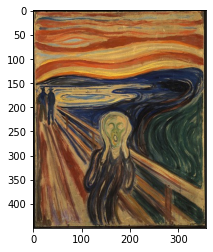

In [ ]:
args = [chrom_len, pop_size, iterations, kids_num, parents_num, sigma_t, sigma_c,
        new_triangles_freq, log_freq, mutation_probability, frames_frequency]
scream = TrianglesGenerator('krzyk.jpg', *args)
scream.show_image(scream.A)

  0%|          | 0/50000 [00:00<?, ?it/s]

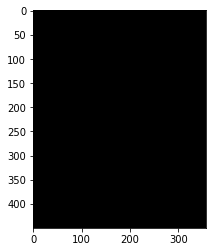

Iteration 0 : best score = 20043.69571695, mean score = 21757.18628181.


In [ ]:
scream.evolve(debug=True)

In [ ]:
scream.show_statistics()

In [ ]:
scream.save_results("mona_lisa")

In [ ]:
scream.show_image(scream.A)
scream.show_image(scream.result)